# Example Notebook for pyBSM Perturbations

This example notebook demonstrates how to run an example image through a series of perturbations of various sensor and scenario parameters in order to see how those parameters affect image quality.

## Table of Contents
* [Set Up the Environment](#environment-setup)
* [Specify Sample Image and Metadata Parameters](#sample-input-image)
* [Simulate Original Image](#simulate-original-image)
* [Select Perturbation Parameters](#select-parameters)
* [Simulate Perturbed Images](#simulate-perturbations)


## Set Up the Environment <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing headless OpenCV...")
# make sure they're both gone.
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  
!{sys.executable} -m pip install -q opencv-python-headless

Installing headless OpenCV...


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pybsm import simulation
import copy
import cv2
import yaml

## Specify Sample Image and Metadata Parameters <a name="sample-input-image"></a>

To get started, you need to provide an image, the ground sample distance (gsd) of that image, and the sensor's estimated altitude (in meters) when the image was captured.

First, a RefImage object is created to store the image and metadata for the original image. If you do not have all the metadata parameters for a sensor, you can use the estimate_capture_parameters function to approximate those parameters given an altitude.

In [3]:
config_path = './config/pybsm_example_config.yaml'
with open(config_path) as file:
    config = yaml.safe_load(file)

img_filename = config['filepath']
img = cv2.imread(img_filename)[:, :, ::-1]

gsd = config['gsd']
ref_img = simulation.RefImage(img, gsd)

#estimate sensor and scenario parameters
sensor, scenario = ref_img.estimate_capture_parameters(altitude=config['scenario']['altitude'])

## Simulate Original Image <a name="simulate-original-image"></a>

Using the sensor and scenario objects with the estimated parameters of the original image, we generate an image that should be as close as possible to the original image. After we generate a simulated image, we stretch the contrast of both images to match the colors in the images.

Reducing integration time from 1 to 0.14947982105590985 to avoid overexposure


C:\Users\maryelise.dedicke\Documents\GitHub\pybsm_gitlab\pybsm\pybsm\otf\functional.py:155: RuntimeWarning: divide by zero encountered in divide
  np.arccos(rho / eta / r0)
C:\Users\maryelise.dedicke\Documents\GitHub\pybsm_gitlab\pybsm\pybsm\otf\functional.py:155: RuntimeWarning: invalid value encountered in divide
  np.arccos(rho / eta / r0)
C:\Users\maryelise.dedicke\Documents\GitHub\pybsm_gitlab\pybsm\pybsm\otf\functional.py:156: RuntimeWarning: divide by zero encountered in divide
  - (rho / eta / r0) * np.sqrt(1.0 - (rho / eta / r0) ** 2.0)
C:\Users\maryelise.dedicke\Documents\GitHub\pybsm_gitlab\pybsm\pybsm\otf\functional.py:156: RuntimeWarning: invalid value encountered in divide
  - (rho / eta / r0) * np.sqrt(1.0 - (rho / eta / r0) ** 2.0)
C:\Users\maryelise.dedicke\Documents\GitHub\pybsm_gitlab\pybsm\pybsm\otf\functional.py:164: RuntimeWarning: divide by zero encountered in divide
  phi = np.arccos((1.0 + eta**2.0 - (2.0 * rho / r0) ** 2) / 2.0 / eta)
C:\Users\maryelise.dedick

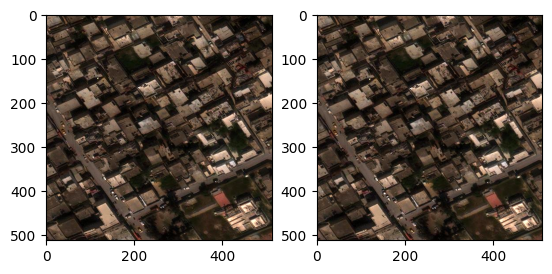

In [4]:
# Note this spits out a bunch of divide by zero errors.
img_out = simulation.simulate_image(ref_img, sensor, scenario)[2]
img_out = simulation.stretch_contrast_convert_8bit(img_out)

plt.figure()
ax1 = plt.subplot(1, 2, 1)
plt.imshow(simulation.stretch_contrast_convert_8bit(ref_img.img))
ax2 = plt.subplot(1, 2, 2)
plt.imshow(img_out)
plt.show()

## Select Perturbation Parameters <a name="select-parameters"></a>

Now that we have a set of parameters that accurately re-creates the source image, we can start to perturb the parameters and see how they affect the image. In this example notebook, we choose one parameter from the sensor and one from the scenario objects to illustrate how they affect the images.

To compare the effect of a parameter on the image quality, we use this function to create a series of sensor and scenario instances with varying parameter values.

In [5]:
def niirsVsRange(sensor,scenario,ranges, parameter):
    # this function allows us to iterate through each ground range
    myobj=[]  
    for r in ranges:
        if parameter == 'groundRange':
            new_scenario = copy.deepcopy(scenario)
            new_scenario.ground_range = r
            metrics = (sensor,new_scenario)
            myobj.append(metrics)
        elif parameter == 'f':
            new_sensor = copy.deepcopy(sensor)
            new_sensor.f = r
            metrics = (new_sensor,scenario)
            myobj.append(metrics)
    return myobj

## Simulate Perturbed Images <a name="simulate-perturbations"></a>

Finally, we set a range of values for the parameters we wish to perturb (ground range and focal length) and simulate an image using each of those values. Plots are generated below that compare the image generated from each set of parameters alongside the original unaltered image.

Reducing integration time from 1 to 0.16250744631900932 to avoid overexposure
Reducing integration time from 1 to 0.18622548089756197 to avoid overexposure
Reducing integration time from 1 to 0.21056960051889267 to avoid overexposure
Reducing integration time from 1 to 0.2331383405224843 to avoid overexposure
Reducing integration time from 1 to 0.2527076053975533 to avoid overexposure


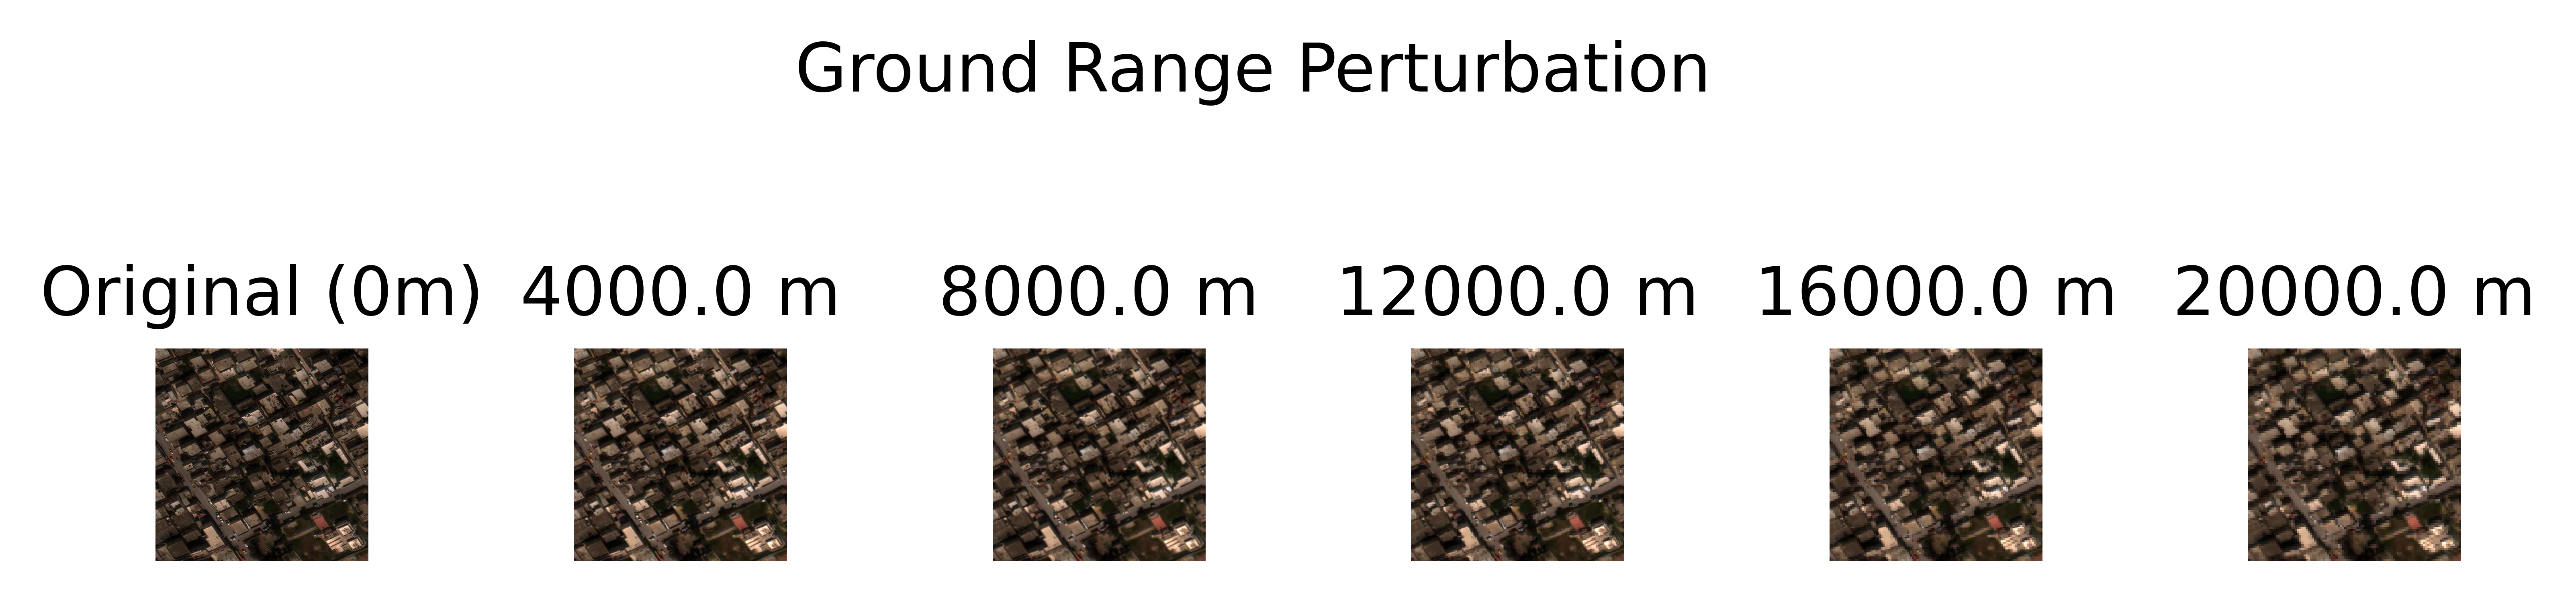

Reducing integration time from 1 to 0.005674486315493016 to avoid overexposure
Reducing integration time from 1 to 0.013848684290211445 to avoid overexposure
Reducing integration time from 1 to 0.021394097805336153 to avoid overexposure
Reducing integration time from 1 to 0.04759345028840806 to avoid overexposure
Reducing integration time from 1 to 0.1890699536969963 to avoid overexposure
Warning!  The simulated image has oversampled the reference image!  This result should not be trusted!!


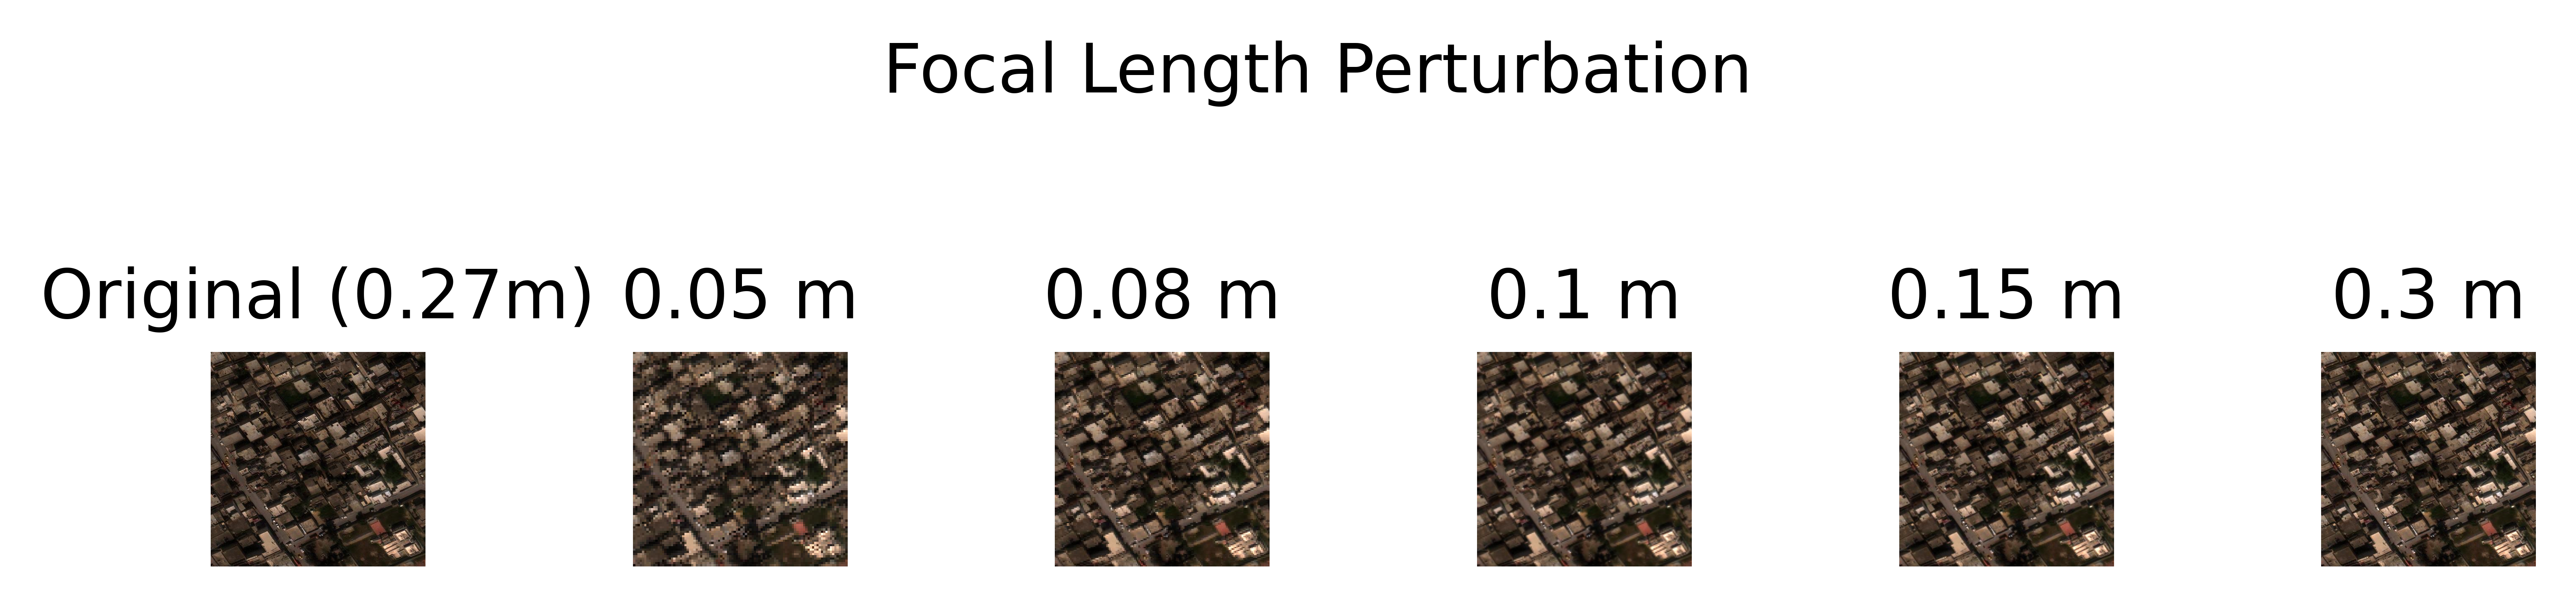

In [6]:
groundRange_range = np.arange(0,24e3,4e3)
f_range = [0.05, 0.08, 0.1, 0.15, 0.3]

#compute the niirs metrics fromt the scenario and sensor parameters
metrics = niirsVsRange(sensor, scenario, groundRange_range, 'groundRange')

#display sequence of degraded images as a function of ground range
fig, axarr = plt.subplots(nrows=1, ncols=6)
fig.set_dpi(1000)
fig.tight_layout()
fig.subplots_adjust(top=1.45)
fig.suptitle("Ground Range Perturbation")
plt.subplot(1,6,1)
plt.axis('off')
plt.title('Original (' + str(scenario.ground_range) +  'm)')
axarr[0].imshow(ref_img.img)

idx=1 #index for the subplots
for ii in np.arange(1, len(groundRange_range)): #index starts at 4 because the 
#shorter range images would have a GSD less than imggsd
    plt.subplot(1,6,idx+1)
    plt.axis('off')
    idx=idx+1
    plt.title(str(groundRange_range[ii]) + ' m')
    
    _, _, img_out = simulation.simulate_image(ref_img, metrics[ii][0], metrics[ii][1])
    img_out = simulation.stretch_contrast_convert_8bit(img_out)
    plt.imshow(img_out)
plt.show()

metrics = niirsVsRange(sensor, scenario, f_range, 'f')

#display sequence of degraded images as a function of ground range
fig2, axarr2 = plt.subplots(nrows=1, ncols=6)
fig2.set_dpi(1000)
fig2.tight_layout()
fig2.subplots_adjust(top=1.45)
fig2.suptitle("Focal Length Perturbation")
plt.subplot(1,6,1)
plt.axis('off')
plt.title('Original (' + str(round(sensor.f, 2)) +  'm)')
axarr2[0].imshow(ref_img.img)

idx=1 #index for the subplots
for ii in np.arange(len(f_range)): #index starts at 4 because the 
#shorter range images would have a GSD less than imggsd
    plt.subplot(1,6,idx+1)
    plt.axis('off')
    idx=idx+1
    plt.title(str(f_range[ii]) + ' m')
    
    _, _, img_out = simulation.simulate_image(ref_img, metrics[ii][0], metrics[ii][1])
    img_out = simulation.stretch_contrast_convert_8bit(img_out)
    plt.imshow(img_out)
plt.show()